<a href="https://colab.research.google.com/github/SpaceJ0392/AI_study/blob/main/visualize_deep_learning/1_01_My_First_CNN_2_2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My First Convolutional Neural Network : MNIST
---
## 일단 Quick 하게

코드는 정말 수루룩 끝난다!

그래서 다시 한 번! 아래 그림을 보고 구조를 확실히 추적할 수 있어야 한다.

* [Ex1](https://cdn-images-1.medium.com/max/1600/1*O9ulXVmjBustHGLi1zRthA.png)
* [Ex2](https://cdn-images-1.medium.com/max/1600/1*jqKHgwZ8alM3K_JRYO_l4w.png)



### Keras Upgrade

In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [ ]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow' # 에러 방지

### 라이브러리 로딩

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random as rd
from sklearn.metrics import accuracy_score

import keras

In [ ]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


정확하게는 28 * 28 * 1의 그림이다 (1은 회색조를 의미)  
케라스가 보정해서 1이 없어도 알아서 잘 하지만, 정확하게는 1을 추가해주어야 한다.

id = 3714
다음 그림은 숫자 6 입니다.


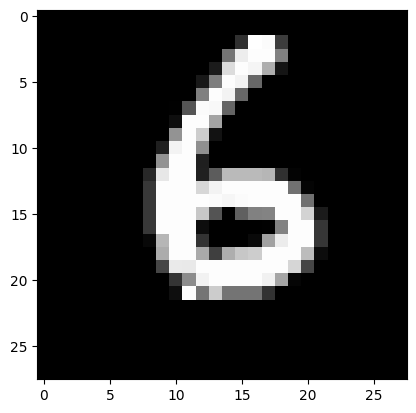

In [ ]:
'''
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0, 10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')
plt.imshow(test_x[id], cmap='gray')
plt.show()

### Convolutional Layer를 사용하기 위한 reshape!

- **채널이 추가되어야 한다**

In [ ]:
train_x.shape, test_x.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
_, h, w = train_x.shape

print(h, w)

28 28


In [ ]:
train_x = train_x.reshape(train_x.shape[0], h, w, 1) # numpy가 제공하는 extend dim 같은 것을 사용해도 된다.
test_x = test_x.reshape(test_x.shape[0], h, w, 1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


* 이미지가 0 ~ 1 사이 값을 갖도록 스케일 조정!  
사실 이미지 데이터만 사용할 때에는 `train_x / 255.` 으로 해도 된다.

In [ ]:
print(f'max : {train_x.max()} , min : {train_x.min()}')

max : 255 , min : 0


In [ ]:
# max_num = train_x.max()

# train_x = train_x / max_num
# test_x = test_x / max_num

In [ ]:
max_n, min_n = train_x.max(), train_x.min()

In [ ]:
train_x = (train_x - min_n) / (max_n - min_n)
test_x = (test_x - min_n) / (max_n - min_n)

In [ ]:
print(f'max : {train_x.max()} , min : {train_x.min()}')

max : 1.0 , min : 0.0


스케일은 안해도, 진행은 가능하나, 스케일링을 했을 때, 학습 속도가 더 빠른 것으로 알려져 있다.

* One-hot Encoding

In [ ]:
from keras.utils import to_categorical

In [ ]:
class_n = len(np.unique(train_y))
class_n

10

In [ ]:
train_y = to_categorical(train_y, class_n)
test_y = to_categorical(test_y, class_n)

**주의**, 만약 `to_categorical`을 반복하면, 차원이 계속 추가 된다.

In [ ]:
train_y.shape

(60000, 10)

## 모델링

- Sequential API, Functional API 중 택일
- CNN에 관한 것만 추가가 된다.
[여기](https://keras.io/layers/convolutional/)를 적극적으로 참고하자.

In [ ]:
train_x.shape, train_y.shape

((60000, 28, 28, 1), (60000, 10))

In [ ]:
from keras.backend import clear_session
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D

from keras.callbacks import EarlyStopping

In [ ]:
## Functional API
# 1. 세션 클리어 : 메모리에 모델 구조가 남아있으면 지워줘.
clear_session() # utils에 자주 사용되는 함수를 넣어 놓아서, back-end가 아니라, utils에서도 clear_session()을 불러 올 수 있다.

# 2. 레이어 엮기 : 사슬처럼!
il = Input(shape=(28,28,1) )

hl = Conv2D(filters=128,       # 새롭게 제작하려는 feature map의 수!
            kernel_size=(3,3), # Convolutional Filter의 가로세로 사이즈! (depth는 케라스가 보정!)
            strides=(1,1),     # Convolutional Filter의 이동 보폭!
            padding='same',    # 패딩 적용 유무! (default = 'valid' => 적용 안함.)
            activation='relu'  # 활성화 함수 반드시!
            )(il)
hl = Conv2D(filters=128,       # 새롭게 제작하려는 feature map의 수!
            kernel_size=(3,3), # Convolutional Filter의 가로세로 사이즈!
            strides=(1,1),     # Convolutional Filter의 이동 보폭!
            padding='same',    # 패딩 적용 유무!
            activation='relu'  # 활성화 함수 반드시!
            )(hl)
hl = MaxPool2D(pool_size=(2,2), # Pooling Filter의 가로세로 크기
               strides=(2,2)    # Pooling Filter의 이동 보폭! (None은 기본적으로 pool_size를 따라감)
               )(hl)

hl = Conv2D(filters=64,       # 새롭게 제작하려는 feature map의 수!
            kernel_size=(3,3), # Convolutional Filter의 가로세로 사이즈!
            strides=(1,1),     # Convolutional Filter의 이동 보폭!
            padding='same',    # 패딩 적용 유무!
            activation='relu'  # 활성화 함수 반드시!
            )(hl)
hl = Conv2D(filters=64,       # 새롭게 제작하려는 feature map의 수!
            kernel_size=(3,3), # Convolutional Filter의 가로세로 사이즈!
            strides=(1,1),     # Convolutional Filter의 이동 보폭!
            padding='same',    # 패딩 적용 유무!
            activation='relu'  # 활성화 함수 반드시!
            )(hl)
hl = MaxPool2D(pool_size=(2,2), # Pooling Filter의 가로세로 크기
               strides=(2,2)    # Pooling Filter의 이동 보폭! (None은 기본적으로 pool_size를 따라감)
               )(hl)

hl = Flatten()(hl)
hl = Dense(128, activation='relu')(hl)
ol = Dense(10, activation='softmax')(hl)

# 3. 모델의 시작과 끝 지정
model = Model(il, ol)

# 4. 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 662,410 (2.53 MB)

 Trainable params: 662,410 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(monitor='val_loss',       # 얼리스토핑 적용할 관측 대상
                   min_delta=0,              # Threshold. 설정한 값 이상으로 변화해야 개선되었다 간주.
                   patience=3,               # 성능 개선이 발생하지 않을 때, 몇 Epochs 더 볼 것인지.
                   verbose=1,
                   restore_best_weights=True # 가장 성능이 좋게 나온 Epoch의 가중치로 되돌림
                   )

In [ ]:
hist = model.fit(train_x, train_y, epochs=5, verbose=1,
                 validation_split=0.2, # 학습 데이터로부터 validation set을 생성!
                 callbacks=[es]
                 )

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9124 - loss: 0.2675 - val_accuracy: 0.9872 - val_loss: 0.0423
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9881 - loss: 0.0411 - val_accuracy: 0.9905 - val_loss: 0.0343
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9907 - loss: 0.0278 - val_accuracy: 0.9925 - val_loss: 0.0278
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9946 - loss: 0.0171 - val_accuracy: 0.9887 - val_loss: 0.0369
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9954 - loss: 0.0148 - val_accuracy: 0.9923 - val_loss: 0.0357
Restoring model weights from the end of the best epoch: 3.


In [ ]:
performance_test = model.evaluate(test_x, test_y)

print(f'Test Loss : {performance_test[0]:.6f} | Test Accuracy : {performance_test[1]*100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9891 - loss: 0.0303
Test Loss : 0.023905 | Test Accuracy : 99.16%


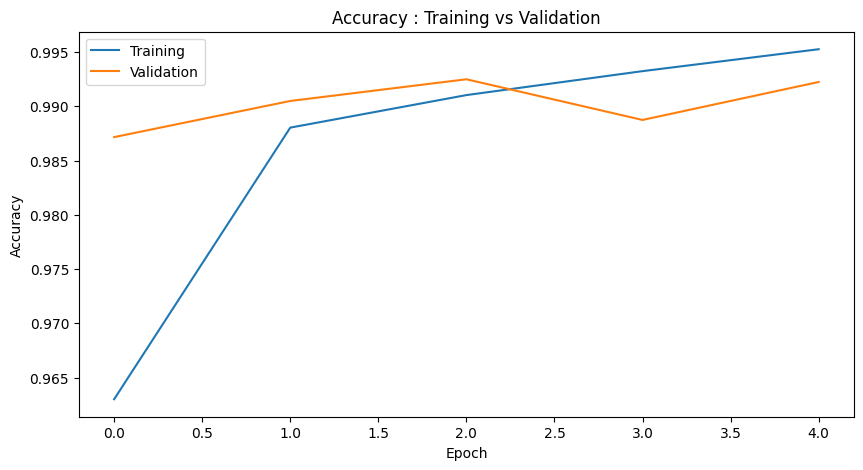

In [ ]:
if not isinstance(hist, dict) :
    history = hist.history

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

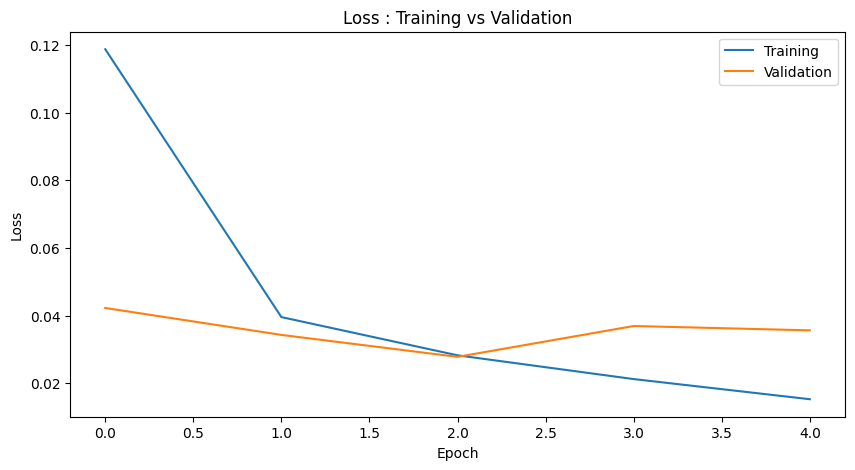

In [ ]:
if not isinstance(hist, dict) :
    history = hist.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

* 예측값 생성

In [ ]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

train_y_arg = train_y.argmax(axis=1)
test_y_arg = test_y.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y_arg, single_pred_train)
logi_test_accuracy = accuracy_score(test_y_arg, single_pred_test)

print('CNN')
print(f'트레이닝 정확도 : {logi_train_accuracy*100:.2f}%' )
print(f'테스트 정확도 : {logi_test_accuracy*100:.2f}%' )

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CNN
트레이닝 정확도 : 99.55%
테스트 정확도 : 99.16%


## 숫자 이미지 시각화

id = 9185
다음 그림은 숫자 6 입니다.
모델의 예측 : 6
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0. 99.  0.  0.  0.]
정답입니다


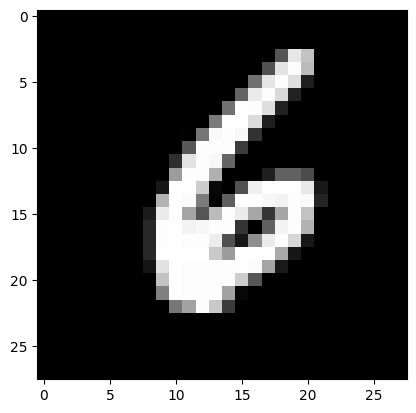

In [ ]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y_arg[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y_arg[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='gray')
plt.show()

id = 3534
다음 그림은 숫자 4 입니다.
모델의 예측 : 8
모델의 카테고리별 확률 : [ 0.  0.  0.  0. 15.  0.  0.  0. 84.  0.]
틀렸어요


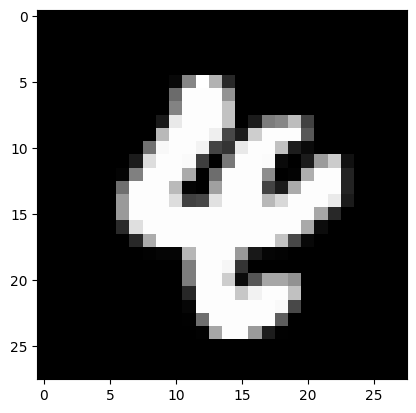

In [ ]:
'''
틀린 것만 관찰해보자!

Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

true_false = (test_y_arg==single_pred_test)
f_id = np.where(true_false==False)[0]
f_n = len(f_id)

id = f_id[rd.randrange(0,f_n)]

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y_arg[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y_arg[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='gray')
plt.show()